In [1]:
% matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pylab

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

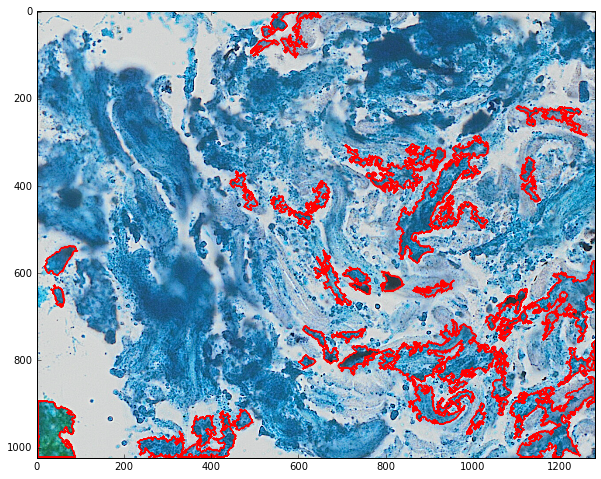

(<matplotlib.image.AxesImage at 0xa55e710>, None)

In [10]:
# -------------------- Determine the main cells ---------------------------------
img = cv2.imread('Images/mp-16-2906_MCT_Ki67_740.tif') 
dot_img = img.copy()
# sharpening the image
image = cv2.GaussianBlur(img, (0,0), 3)
img = cv2.addWeighted(img, 1.5, image, -0.5, 0)
# color thresholding
yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
im_th = cv2.inRange(yuv, (0,0,0), (150,255,255))

cells = []
# finding contours in the image
c, _ = cv2.findContours(im_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for cnt in c:
    area = cv2.contourArea(cnt)
    true_area = cv2.contourArea(cnt, True)
    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio = float(w)/h
    # keeping only the "valid" cells
    if area > 500 and aspect_ratio > 0.6 and area < 20000 and true_area < 0: 
        cv2.drawContours(img, [cnt], -1, (255,0,0), 3)
        cells.append(cnt)
plt.imshow(img), plt.show()

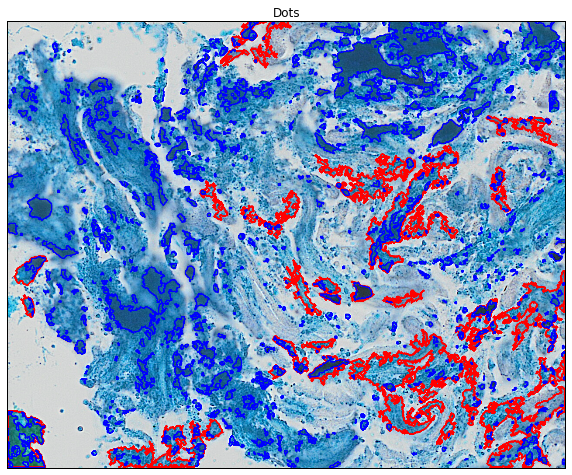

(<matplotlib.image.AxesImage at 0xa934978>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [11]:
# -------------------- Detect the dots in an image -------------------------------
b,g,r = cv2.split(dot_img)
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

# converting to hsv
np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0] - rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

# thresholding the dots found
dot_points = cv2.inRange(mask, (0, 50, 0), (255,255,150))
c, heirarchy = cv2.findContours(dot_points, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

dots = []
# keep only the dot contours larger than 10 px
for cnt in c:
    if cv2.contourArea(cnt) > 10:
        dots.append(cnt)
        
cv2.drawContours(img, dots, -1, (0,0,255),2)
plt.imshow(img), plt.xticks([]), plt.yticks([]), plt.title("Dots"), plt.show()

In [12]:
# ------------ Counting the number of dots in cells -----------------------------------
print('# of Dots: {}'.format(len(dots)))
print('# of Cells: {}'.format(len(cells)))
total = {}
track = -1
# doing the point polygon test to check dot was within a cell
for i in range(len(dots)):
    for j in range(len(dots[i])):
        for m in range(len(cells)):
            x = dots[i][j][0][0]
            y = dots[i][j][0][1]
            points = (x,y)
            num  = cv2.pointPolygonTest(cells[m], points, False )
            if num == 0 or num == 1:
                moment = cv2.moments(cells[m])
                if moment['m00'] != 0.0:
                    cx = moment['m10']/moment['m00']
                    cy = moment['m01']/moment['m00']
                    centroid = (cx,cy)
                    if centroid in total and track != i:
                        total[centroid] += 1
                        track += 1
                    elif centroid not in total and track != i:
                        total[centroid] = 1
                        track += 1

average = 0
for k,v in total.iteritems():
    average += v
    #print("{}: {}".format(k,v))
    
average = average / len(total)
print("Average: {}".format(average))

# of Dots: 858
# of Cells: 35
Average: 26


In [17]:
# ---------------------------- RUN ON MULTIPLE IMAGES ----------------------------------
file_path = os.listdir("Images/")
yellow_test = open('Yellow_Test6.txt', 'w')
yellow_test.write("Image\t# Of Cells\tTotal Cell Area\tDots per Cell\n")
for infile in file_path:
    if "Ki67" in infile:
        img = cv2.imread('Images/'+infile)
        dot_img = img.copy()
        # sharpening the image
        image = cv2.GaussianBlur(img, (0,0), 3)
        img = cv2.addWeighted(img, 1.5, image, -0.5, 0)
        # color thresholding
        yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        im_th = cv2.inRange(yuv, (0,0,0), (150,255,255))

        cells = []
        # finding contours in the image
        c, _ = cv2.findContours(im_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for cnt in c:
            area = cv2.contourArea(cnt)
            true_area = cv2.contourArea(cnt, True)
            x,y,w,h = cv2.boundingRect(cnt)
            aspect_ratio = float(w)/h
            # keeping only the "valid" cells
            if area > 500 and aspect_ratio > 0.6 and area < 20000 and true_area < 0: 
                cv2.drawContours(img, [cnt], -1, (255,0,0), 3)
                cells.append(cnt)
                
        b,g,r = cv2.split(dot_img)
        rg = cv2.merge([r,g,b])
        rg = rg.astype(np.float32)

        # converting to hsv
        np.seterr(all = 'ignore')
        mask = np.empty_like(rg)
        arr_max = rg.max(-1)
        delta = rg.ptp(-1)
        s = delta/arr_max
        s[delta==0]=0
        idx = (rg[:,:,0] == arr_max)
        mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
        idx = (rg[:,:,1] == arr_max)
        mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
        idx = (rg[:,:,2] == arr_max)
        mask[idx,0] = 4. + np.true_divide((rg[idx,0] - rg[idx,1]), delta[idx])
        mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
        mask[:,:,0] = np.nan_to_num(mask[:,:,0])
        mask[:,:,1] = s * 255.0
        mask[:,:,2] = arr_max
        mask = mask.astype(np.uint8)

        # thresholding the dots found
        dot_points = cv2.inRange(mask, (0, 50, 0), (255,255,150))
        c, heirarchy = cv2.findContours(dot_points, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        dots = []
        # keep only the dot contours larger than 10 px
        for cnt in c:
            if cv2.contourArea(cnt) > 10:
                dots.append(cnt)

        cv2.drawContours(img, dots, -1, (0,0,255),2)
                
        total = {}
        track = -1
        # doing the point polygon test to check dot was within a cell
        for i in range(len(dots)):
            for j in range(len(dots[i])):
                for m in range(len(cells)):
                    x = dots[i][j][0][0]
                    y = dots[i][j][0][1]
                    points = (x,y)
                    num  = cv2.pointPolygonTest(cells[m], points, False )
                    if num == 0 or num == 1:
                        moment = cv2.moments(cells[m])
                        if moment['m00'] != 0.0:
                            cx = moment['m10']/moment['m00']
                            cy = moment['m01']/moment['m00']
                            centroid = (cx,cy)
                            if centroid in total and track != i:
                                total[centroid] += 1
                                track += 1
                            elif centroid not in total and track != i:
                                total[centroid] = 1
                                track += 1

        average = 0
        for k,v in total.iteritems():
            average += v
            #print("{}: {}".format(k,v))

        if len(total) != 0.0:
            average = average / len(total)
        else:
            average = 0
        print("{}: {}".format(infile, average))
        yellow_test.write(infile+'\t'+str(len(cells))+'\t'+str(cell_area)+'\t'+str(average)+'\n')
        cv2.imwrite("Yellow_Test6_Mask/"+infile, cell_mask)
        cv2.imwrite("Yellow_Test6_Orig/"+infile, cell_img)
yellow_test.close()

mp-16-2852_MCT_Ki67_012.tif: 0
mp-16-2852_MCT_Ki67_041.tif: 2
mp-16-2852_MCT_Ki67_1053.tif: 2
mp-16-2852_MCT_Ki67_1064.tif: 30
mp-16-2852_MCT_Ki67_1153.tif: 2
mp-16-2852_MCT_Ki67_1200.tif: 2
mp-16-2852_MCT_Ki67_1318.tif: 3
mp-16-2852_MCT_Ki67_1396.tif: 3
mp-16-2852_MCT_Ki67_1424.tif: 2
mp-16-2852_MCT_Ki67_1494.tif: 0
mp-16-2852_MCT_Ki67_1501.tif: 2
mp-16-2852_MCT_Ki67_1534.tif: 2
mp-16-2852_MCT_Ki67_1682.tif: 3
mp-16-2852_MCT_Ki67_1694.tif: 3
mp-16-2852_MCT_Ki67_1695.tif: 3
mp-16-2852_MCT_Ki67_1696.tif: 3
mp-16-2852_MCT_Ki67_1697.tif: 2
mp-16-2852_MCT_Ki67_1698.tif: 2
mp-16-2852_MCT_Ki67_1699.tif: 2
mp-16-2852_MCT_Ki67_1707.tif: 3
mp-16-2852_MCT_Ki67_1721.tif: 2
mp-16-2852_MCT_Ki67_1731.tif: 2
mp-16-2852_MCT_Ki67_1732.tif: 2
mp-16-2852_MCT_Ki67_1736.tif: 2
mp-16-2852_MCT_Ki67_1843.tif: 2
mp-16-2852_MCT_Ki67_1850.tif: 2
mp-16-2852_MCT_Ki67_1873.tif: 2
mp-16-2852_MCT_Ki67_1889.tif: 2
mp-16-2852_MCT_Ki67_208.tif: 2
mp-16-2852_MCT_Ki67_2110.tif: 2
mp-16-2852_MCT_Ki67_2152.tif: 2
mp-16-2852

In [18]:
print('done')

done
